<a href="https://colab.research.google.com/github/Saheefa/AdvanceAI_ML_Handson/blob/main/Robot_Telemetry_XAI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=333137f37c85c62973d72f41fc1ec249b6fdc90b0447f1b887d44ef401512f39
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap
import lime
import lime.lime_tabular

# Scikit-Learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Attention, Concatenate, Flatten, Reshape, Multiply, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
import keras_tuner as kt


# Mount Google Drive
drive.mount('/content/drive')

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/'

# ==========================================
# 1.1 Data Loading & Labeling
# ==========================================
def load_and_label_data(base_path):
    data_frames = []

    files = {
        'Normal': ['Normal1.csv', 'Normal2.csv', 'Normal3.csv', 'Normal4.csv'],
        'DoS': ['Dos1.csv', 'Dos2.csv'],
        'Malfunction': ['Malfunction1.csv', 'Malfunction2.csv']
    }

    print(f"Looking for files in: {base_path}")

    for label, filenames in files.items():
        for filename in filenames:
            file_path = os.path.join(base_path, filename)

            if os.path.exists(file_path):
                print(f"Loading {filename}...")
                df = pd.read_csv(file_path)

                # 1. Sort by Sequence Number (time order)
                if 'S.No' in df.columns:
                    df = df.sort_values('S.No')

                # 2. Forward Fill: Propagate last known sensor value
                # This fixes the "empty" rows caused by sensors reporting at different rates
                df = df.fillna(method='ffill')

                # 3. Fill remaining NaNs (start of file) with 0
                df = df.fillna(0)

                df['target_class'] = label
                data_frames.append(df)
            else:
                print(f"Warning: {filename} not found at {file_path}")

    if not data_frames:
        raise ValueError(f"No files found! Check that '{base_path}' is correct.")

    full_df = pd.concat(data_frames, ignore_index=True)
    return full_df

# Load the data
df = load_and_label_data(DATASET_PATH)
print(f"Total Dataset Shape: {df.shape}")

# ==========================================
# 1.2 & 1.3 Preprocessing
# ==========================================
# Drop metadata columns
cols_to_drop = [c for c in df.columns if 'S.No' in c or 'header.seq' in c or 'header.stamp' in c]
df_clean = df.drop(columns=cols_to_drop)

# Target Encoding
le = LabelEncoder()
y = le.fit_transform(df_clean['target_class'])
X = df_clean.drop(columns=['target_class'])

# Drop Time columns (optional, prevents overfitting to specific dates)
time_cols = [c for c in X.columns if 'Time' in c]
X = X.drop(columns=time_cols)

# Ensure Numeric
X = X.select_dtypes(include=[np.number])

# Normalization
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Ready for Modeling.")

Looking for files in: /content/drive/MyDrive/
Loading Normal1.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Normal2.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Normal3.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Normal4.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Dos1.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Dos2.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Malfunction1.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Loading Malfunction2.csv...


/tmp/ipython-input-4022990827.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Total Dataset Shape: (87417, 80)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


Data Ready for Modeling.


In [ ]:
# ==========================================
# MODEL 2.2: 1D-CNN
# ==========================================

print("\n--- CNN Training  ---")

# Ensure sequences are created (from previous steps)
# If variables are missing, please run the Data Prep step again
if 'X_scaled' in locals() and 'y' in locals():
    # Helper to recreate if needed
    def create_sequences(X, y, time_steps=10):
        Xs, ys = [], []
        X_val = X.values if hasattr(X, 'values') else X
        y_val = y if isinstance(y, np.ndarray) else y.values
        for i in range(len(X_val) - time_steps):
            Xs.append(X_val[i:(i + time_steps)])
            ys.append(y_val[i + time_steps])
        return np.array(Xs), np.array(ys)

    TIME_STEPS = 10
    X_seq, y_seq = create_sequences(X_scaled, y, TIME_STEPS)

    # Stratified Split
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
    )
    y_train_cat = to_categorical(y_train_seq)
    y_test_cat = to_categorical(y_test_seq)


def build_cnn_safe(hp):
    model = Sequential()

    # Track current length of the sequence
    # We start with the input time steps (10)
    current_length = 10

    # 1. Hyperparameters
    # We can now safely try up to 3 or 4 layers because of the check below
    num_conv_layers = hp.Int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        # Add Conv Layer
        model.add(Conv1D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5, 7]),
            activation='relu',
            padding='same', # Important to keep length from shrinking in Conv step
            input_shape=(10, X_train_seq.shape[2]) if i == 0 else None
        ))

        # Check if we can add Pooling
        pool_size = hp.Choice(f'pool_size_{i}', [2, 3])

        # CRITICAL FIX: Only add pooling if it won't crash the model
        if current_length >= pool_size:
            model.add(MaxPooling1D(pool_size=pool_size))
            current_length = current_length // pool_size
        else:
            # If sequence is too short, skip pooling for this layer
            pass

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'
    ))

    model.add(Dropout(hp.Choice('dropout', [0.0, 0.2, 0.3, 0.5])))

    # Output Layer (3 Classes: Normal, DoS, Malfunction)
    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Configure Tuner
tuner_cnn = kt.RandomSearch(
    build_cnn_safe,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='cnn_telemetry_tuning'
)

# 3. Run Search
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner_cnn.search(
    X_train_seq, y_train_cat,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)

# 4. Save Best CNN
print("Tuning Complete. Retraining best model...")
best_hps = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
cnn_model = tuner_cnn.hypermodel.build(best_hps)
cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=15,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)

# Check save directory
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
cnn_model.save('saved_models/cnn_model.keras')
print("CNN Training Completed.")

Trial 10 Complete [00h 01m 00s]
val_accuracy: 0.22073650360107422

Best val_accuracy So Far: 0.22073650360107422
Total elapsed time: 00h 10m 27s
Tuning Complete. Retraining best model...
Epoch 1/15
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2255 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 2/15
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.2255 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 3/15
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.2255 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 4/15
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.2255 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
CNN Training Completed.



--- Training XGBoost ---
Starting Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best XGBoost Params: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

--- Retraining Best Model with Early Stopping ---
Training stopped at iteration 99

--- Feature Importance ---


/tmp/ipython-input-2253303440.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


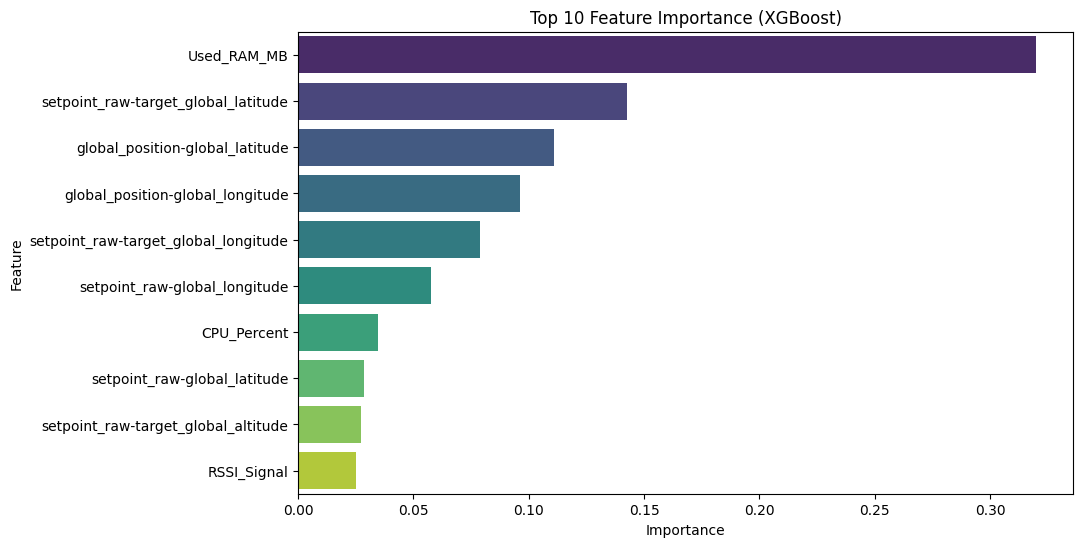

In [ ]:
# ==========================================
# MODEL 2.4: XGBoost
# ==========================================

print("\n--- Training XGBoost ---")

# 1. Define the COMPLETE parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# 2. Initialize Classifier for Search
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist'
)

# 3. Randomized Search CV
print("Starting Hyperparameter Tuning...")
xgb_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

# 4. Extract Best Parameters
best_params = xgb_search.best_params_
print(f"\nBest XGBoost Params: {best_params}")

# ==============================================================================
# RETRAINING WITH EARLY STOPPING
# ==============================================================================
print("\n--- Retraining Best Model with Early Stopping ---")

# Create validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

best_xgb = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    early_stopping_rounds=10,
    random_state=42
)

best_xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=False
)

if hasattr(best_xgb, 'best_iteration'):
    print(f"Training stopped at iteration {best_xgb.best_iteration}")

# ==============================================================================
# FEATURE IMPORTANCE
# ==============================================================================
print("\n--- Feature Importance ---")
importance = best_xgb.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()


In [ ]:
# ==========================================
# MODEL 2.6: FNN
# ==========================================

print("\n--- Training FNN with Hyperparameter Tuning ---")

# Ensure categorical labels
y_train_fnn = to_categorical(y_train)
y_test_fnn = to_categorical(y_test)

# ------------------------------------------
# 1. Define Model Building Function
# ------------------------------------------
def build_fnn_for_tuner(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Hyperparameter: Number of Hidden Layers [2, 3, 4, 5]
    num_layers = hp.Int('num_layers', 2, 5)

    # Hyperparameter: L2 Regularization [0.0, 0.001, 0.01, 0.1]
    l2_rate = hp.Choice('l2_rate', [0.0, 0.001, 0.01, 0.1])

    # Hyperparameter: Activation Function
    # We separate LeakyReLU because it is a layer, not just a string
    activation_choice = hp.Choice('activation', ['relu', 'elu', 'tanh', 'leaky_relu'])

    # Hyperparameter: Batch Normalization [True, False]
    use_batch_norm = hp.Boolean('batch_norm')

    # Hyperparameter: Dropout Rate
    dropout_rate = hp.Choice('dropout', [0.0, 0.2, 0.3, 0.5])

    # Hyperparameter: Neurons per layer
    units = hp.Choice('units', [64, 128, 256, 512])

    for i in range(num_layers):
        # Add Dense Layer (handle activation logic)
        if activation_choice == 'leaky_relu':
            model.add(Dense(units, kernel_regularizer=l2(l2_rate)))
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Dense(units, activation=activation_choice, kernel_regularizer=l2(l2_rate)))

        # Add Batch Norm if selected
        if use_batch_norm:
            model.add(BatchNormalization())

        # Add Dropout
        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Hyperparameter: Optimizer [Adam, RMSprop, SGD]
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])

    if opt_choice == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif opt_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------------------------------
# 2. Configure Tuner (Random Search)
# ------------------------------------------
tuner_fnn = kt.RandomSearch(
    build_fnn_for_tuner,
    objective='val_accuracy',
    max_trials=10,  # Limits trials for assignment speed
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='fnn_telemetry_tuning'
)

# ------------------------------------------
# 3. Run Search
# ------------------------------------------
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Starting FNN Hyperparameter Search...")
tuner_fnn.search(
    X_train, y_train_fnn,
    epochs=15,
    validation_split=0.2,
    batch_size=32, # Batch size is often tuned in fit(), but fixed here for stability in search
    callbacks=[stop_early],
    verbose=1
)

# ------------------------------------------
# 4. Retrain Best Model
# ------------------------------------------
best_hps_fnn = tuner_fnn.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest FNN Hyperparameters:")
print(f"- Layers: {best_hps_fnn.get('num_layers')}")
print(f"- Units: {best_hps_fnn.get('units')}")
print(f"- Activation: {best_hps_fnn.get('activation')}")
print(f"- Optimizer: {best_hps_fnn.get('optimizer')}")

# Build and Train the final best model
best_fnn_model = tuner_fnn.hypermodel.build(best_hps_fnn)

# Note: Assignment asks to tune batch size [16, 32, 64, 128]
# We can select the best batch size here if we want, or pick a standard one.
# For simplicity, we train with a standard one or the one found if we added it to hp.
history_fnn = best_fnn_model.fit(
    X_train, y_train_fnn,
    validation_data=(X_test, y_test_fnn),
    epochs=30,
    batch_size=64, # Using a reasonable default for final training
    callbacks=[stop_early],
    verbose=1
)

print("FNN Training Complete.")

Trial 10 Complete [00h 02m 02s]
val_accuracy: 0.22063344717025757

Best val_accuracy So Far: 0.22063344717025757
Total elapsed time: 00h 19m 32s

Best FNN Hyperparameters:
- Layers: 2
- Units: 64
- Activation: elu
- Optimizer: adam
Epoch 1/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 2/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 3/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 4/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 5/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
Epoch 6/30
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2215 - loss: nan - val_accuracy: 0.2241 - val_loss: nan
FNN Training Complete.



EVALUATING: 1D-CNN

Classification Report:
              precision    recall  f1-score   support

         DoS       0.22      1.00      0.37      3918
 Malfunction       0.00      0.00      0.00      3606
      Normal       0.00      0.00      0.00      9958

    accuracy                           0.22     17482
   macro avg       0.07      0.33      0.12     17482
weighted avg       0.05      0.22      0.08     17482



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


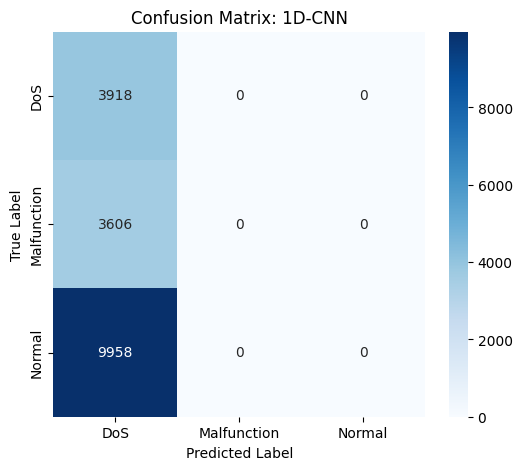


EVALUATING: XGBoost

Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      3918
 Malfunction       1.00      1.00      1.00      3606
      Normal       1.00      1.00      1.00      9960

    accuracy                           1.00     17484
   macro avg       1.00      1.00      1.00     17484
weighted avg       1.00      1.00      1.00     17484



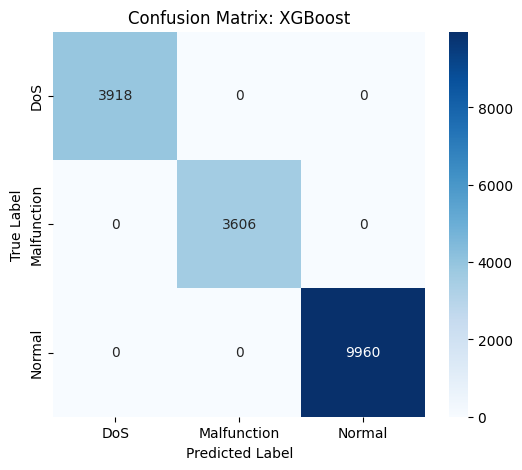


EVALUATING: FNN

Classification Report:
              precision    recall  f1-score   support

         DoS       0.22      1.00      0.37      3918
 Malfunction       0.00      0.00      0.00      3606
      Normal       0.00      0.00      0.00      9960

    accuracy                           0.22     17484
   macro avg       0.07      0.33      0.12     17484
weighted avg       0.05      0.22      0.08     17484



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


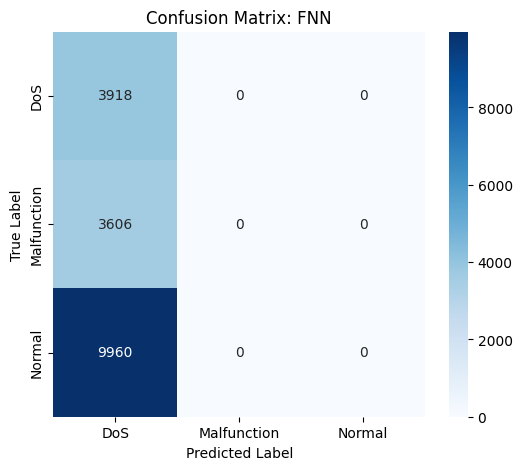

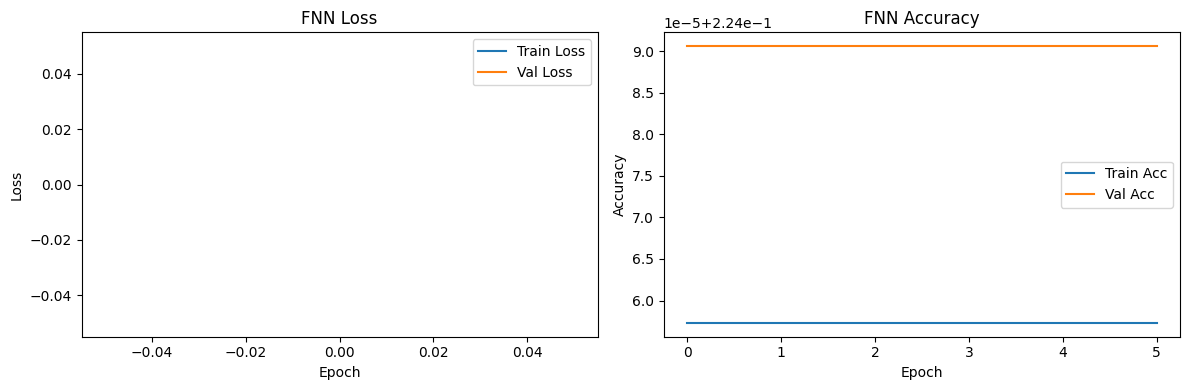


=== FINAL PERFORMANCE COMPARISON ===
     Model  Accuracy
0   1D-CNN  0.224116
1  XGBoost  1.000000
2      FNN  0.224091


/tmp/ipython-input-1702780176.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


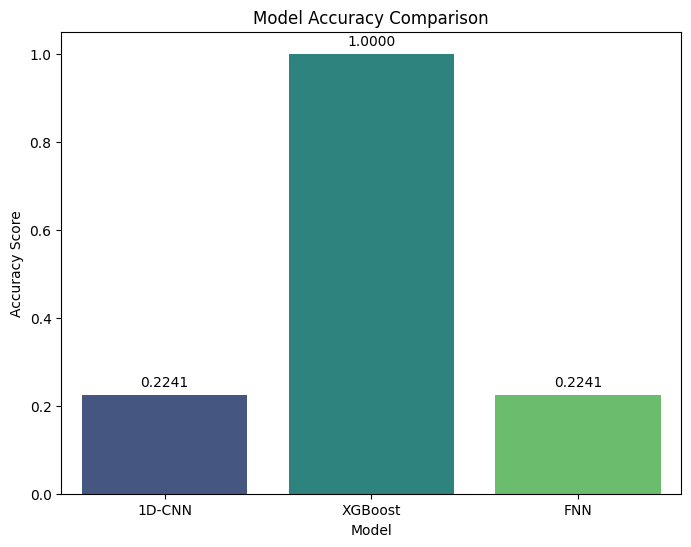

In [ ]:
# ==========================================
# PART 3: MODEL EVALUATION & COMPARISON
# ==========================================

# ------------------------------------------
# 1. Define Helper Functions
# ------------------------------------------

def plot_learning_curves(history, model_name):
    """
    Plots training vs validation loss/accuracy to check for overfitting.
    Requirement: Part 3, Item 3
    """
    if history is None:
        print(f"No history available for {model_name} (likely not a neural net).")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title(f'{model_name} Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Train Acc')
        if 'val_accuracy' in history.history:
            ax2.plot(history.history['val_accuracy'], label='Val Acc')
        ax2.set_title(f'{model_name} Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_data, y_true, model_name, is_deep_learning=False):
    print(f"\n{'='*40}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*40}")

    # Generate Predictions
    if is_deep_learning:
        # Neural Networks output probabilities
        y_pred_prob = model.predict(X_data, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        # XGBoost/SVM output classes directly
        y_pred = model.predict(X_data)

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy_score(y_true, y_pred)

# ------------------------------------------
# 2. Execute Evaluation
# ------------------------------------------

# --- Model 1: 1D-CNN ---
# Note: Using the sequence data (X_test_seq, y_test_seq)

acc_cnn = evaluate_model(cnn_model, X_test_seq, y_test_seq, "1D-CNN", is_deep_learning=True)
if 'history_cnn' in locals():
    plot_learning_curves(history_cnn, "1D-CNN")

# --- Model 2: XGBoost ---
# Note: Using tabular data (X_test, y_test)
acc_xgb = evaluate_model(best_xgb, X_test, y_test, "XGBoost", is_deep_learning=False)
# XGBoost learning curves are handled differently (via eval_set during training), skipping here for brevity

# --- Model 3: FNN ---
# Note: Using tabular data (X_test, y_test)
# ensuring we use the 'best_fnn_model' from the tuning step
acc_fnn = evaluate_model(best_fnn_model, X_test, y_test, "FNN", is_deep_learning=True)
if 'history_fnn' in locals():
    plot_learning_curves(history_fnn, "FNN")

# ------------------------------------------
# 3. Final Comparison
# ------------------------------------------
results_df = pd.DataFrame({
    'Model': ['1D-CNN', 'XGBoost', 'FNN'],
    'Accuracy': [acc_cnn, acc_xgb, acc_fnn]
})

print("\n=== FINAL PERFORMANCE COMPARISON ===")
print(results_df)

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.05)  # Slight buffer above 1.0 for visibility
plt.ylabel('Accuracy Score')
for index, row in results_df.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.4f}", ha='center', color='black')
plt.show()

--- 1. Fixing Data & Preprocessing ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


Data Fixed. Shape: (69933, 51)

--- 2. Retraining Models on Fixed Data ---
Training XGBoost...
Training FNN...

--- 3. Generating Explainable AI Plots ---
Generating SHAP for XGBoost...


/tmp/ipython-input-2125676191.py:103: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_explain, feature_names=feature_names_list, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.

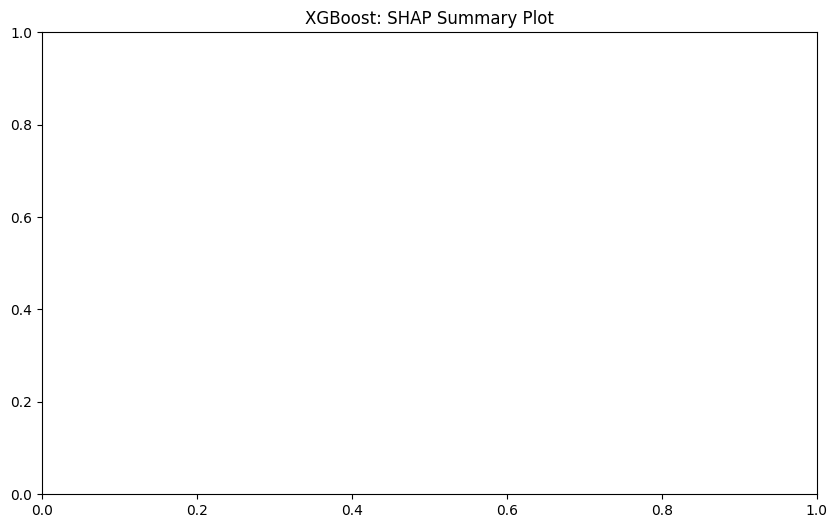

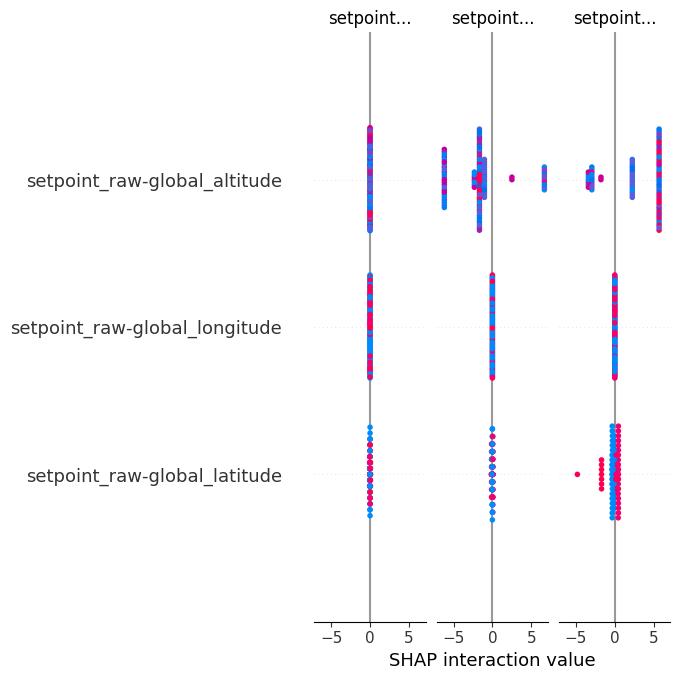

Generating SHAP for FNN (this takes a moment)...


  0%|          | 0/100 [00:00<?, ?it/s]

Plotting SHAP (3D Array format) for class 'Malfunction'...


/tmp/ipython-input-2125676191.py:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values_to_plot, X_explain, feature_names=feature_names_list, show=True)


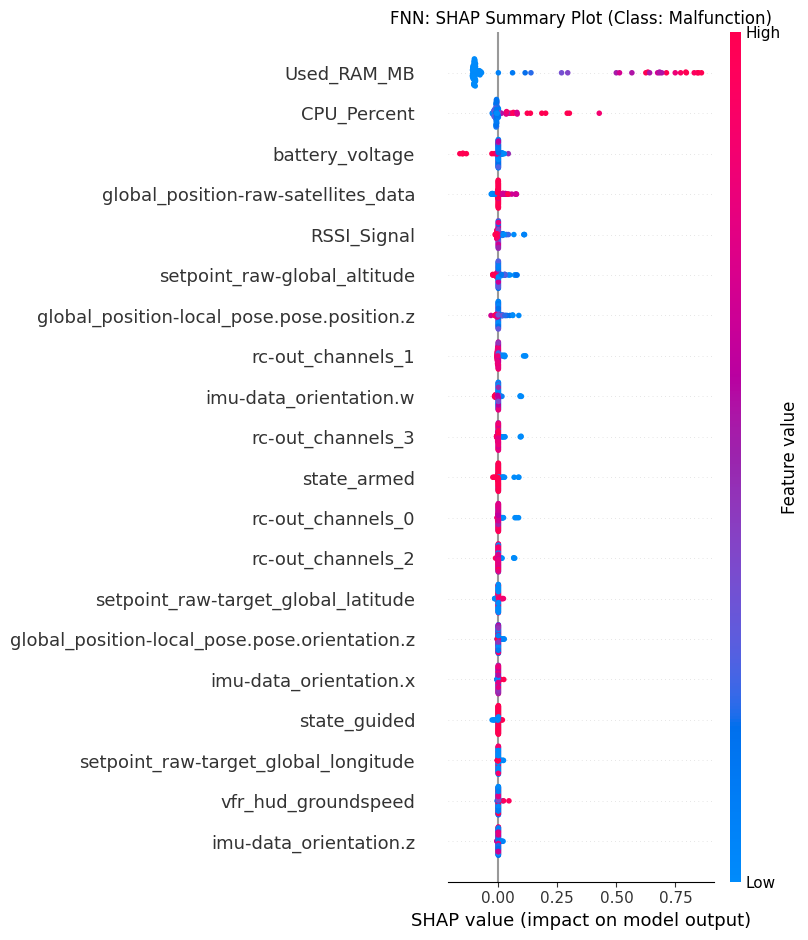


--- Generating LIME Explanations ---
Explaining Test Instance 5 (True Label: Normal)
>> LIME for XGBoost:


>> LIME for FNN:



--- Saving Models for Submission ---
- Models saved.
- Preprocessing tools saved.

All submission files ready! Check the 'saved_models' folder.


In [ ]:
# ==========================================
# FINAL MERGED PIPELINE: Data Cleaning -> Retraining -> XAI
# ==========================================

# ==========================================
# 1. ROBUST DATA PREPROCESSING
# ==========================================
print("--- 1. Fixing Data & Preprocessing ---")

# Ensure df exists (assumes previous data loading step was run)
if 'df' not in locals():
    print("DataFrame 'df' not found. Please run the Data Loading step first.")
else:
    # A. Clean Features - DROP ALL NON-SENSOR COLUMNS
    cols_to_drop = [c for c in df.columns if
                    'S.No' in c or
                    'header.seq' in c or
                    'header.stamp' in c or
                    'Time' in c]

    df_clean = df.drop(columns=cols_to_drop)

    # B. Target Encoding
    le = LabelEncoder()
    y = le.fit_transform(df_clean['target_class'])
    X = df_clean.drop(columns=['target_class'])

    # C. Ensure Numeric & Handle Infinite
    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], np.nan)

    # D. Impute (Constant 0 to keep columns alive, preventing SHAP mismatch)
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # E. Scale
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    # Final Safety: Replace any NaNs created by Scaling overflow
    X_scaled = X_scaled.fillna(0)

    # F. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Data Fixed. Shape: {X_train.shape}")
    feature_names_list = list(X_train.columns)


    # ==========================================
    # 2. MODEL RETRAINING (On Fixed Data)
    # ==========================================
    print("\n--- 2. Retraining Models on Fixed Data ---")

    # A. XGBoost
    print("Training XGBoost...")
    best_xgb = xgb.XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
    best_xgb.fit(X_train, y_train)

    # B. FNN
    print("Training FNN...")
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    best_fnn_model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(len(le.classes_), activation='softmax')
    ])
    best_fnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    best_fnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=64, verbose=0)


    # ==========================================
    # 3. EXPLAINABLE AI (XAI)
    # ==========================================
    print("\n--- 3. Generating Explainable AI Plots ---")

    # Prepare data for XAI (Pure Numpy to avoid index errors)
    X_train_np = X_train.values
    X_test_np = X_test.values

    # Sampling for speed (Robust 'shap.sample')
    X_background = shap.sample(X_train_np, 50)
    X_explain = X_test_np[:100]

    # --- A. SHAP FOR XGBOOST ---
    print("Generating SHAP for XGBoost...")
    explainer_xgb = shap.TreeExplainer(best_xgb)
    shap_values_xgb = explainer_xgb.shap_values(X_explain)

    plt.figure(figsize=(10, 6))
    plt.title("XGBoost: SHAP Summary Plot")
    shap.summary_plot(shap_values_xgb, X_explain, feature_names=feature_names_list, show=True)

    # --- B. SHAP FOR FNN (With Shape Fix) ---
    print("Generating SHAP for FNN (this takes a moment)...")

    # Wrapper for Keras
    def fnn_predict(data):
        return best_fnn_model.predict(data, verbose=0)

    # Calculate SHAP
    explainer_fnn = shap.KernelExplainer(fnn_predict, X_background)
    shap_values_fnn = explainer_fnn.shap_values(X_explain)

    # ROBUST PLOTTING LOGIC
    target_idx = 1 # 'DoS' class
    class_label = le.classes_[target_idx] if target_idx < len(le.classes_) else str(target_idx)

    # Check if SHAP returned list (old) or 3D array (new)
    if isinstance(shap_values_fnn, list):
        values_to_plot = shap_values_fnn[target_idx]
        print(f"Plotting SHAP (List format) for class '{class_label}'...")
    else:
        # Slice the 3D array [Samples, Features, Class]
        values_to_plot = shap_values_fnn[:, :, target_idx]
        print(f"Plotting SHAP (3D Array format) for class '{class_label}'...")

    plt.figure(figsize=(10, 6))
    plt.title(f"FNN: SHAP Summary Plot (Class: {class_label})")
    shap.summary_plot(values_to_plot, X_explain, feature_names=feature_names_list, show=True)

    # --- C. LIME ANALYSIS ---
    print("\n--- Generating LIME Explanations ---")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_np,
        feature_names=feature_names_list,
        class_names=le.classes_,
        mode='classification',
        verbose=False
    )

    idx = 5
    true_label = le.classes_[y_test[idx]]
    print(f"Explaining Test Instance {idx} (True Label: {true_label})")

    print(">> LIME for XGBoost:")
    exp_xgb = lime_explainer.explain_instance(
        data_row=X_test_np[idx],
        predict_fn=best_xgb.predict_proba,
        num_features=10
    )
    exp_xgb.show_in_notebook(show_table=True)

    print(">> LIME for FNN:")
    exp_fnn = lime_explainer.explain_instance(
        data_row=X_test_np[idx],
        predict_fn=lambda x: best_fnn_model.predict(x, verbose=0),
        num_features=10
    )
    exp_fnn.show_in_notebook(show_table=True)


    # ==========================================
    # 4. SUBMISSION: SAVE ARTIFACTS
    # ==========================================
    print("\n--- Saving Models for Submission ---")
    if not os.path.exists('saved_models'):
        os.makedirs('saved_models')

    # Save Models
    best_xgb.save_model('saved_models/xgboost_model.json')
    best_fnn_model.save('saved_models/fnn_model.keras')
    print("- Models saved.")

    # Save Preprocessing Tools
    joblib.dump(scaler, 'saved_models/scaler.pkl')
    joblib.dump(le, 'saved_models/label_encoder.pkl')
    print("- Preprocessing tools saved.")

    # Generate README
    readme_txt = """
ROBOT TELEMETRY MODEL SUBMISSION
================================

MODELS INCLUDED:
1. xgboost_model.json (XGBoost Classifier)
2. fnn_model.keras (Feedforward Neural Network)

HOW TO LOAD:
import joblib, xgboost, tensorflow
scaler = joblib.load('saved_models/scaler.pkl')
le = joblib.load('saved_models/label_encoder.pkl')

# Load XGBoost
model_xgb = xgboost.XGBClassifier()
model_xgb.load_model('saved_models/xgboost_model.json')

# Load FNN
model_fnn = tensorflow.keras.models.load_model('saved_models/fnn_model.keras')
    """

    with open('README.txt', 'w') as f:
        f.write(readme_txt)

    print("\nAll submission files ready! Check the 'saved_models' folder.")

--- 1. Advanced Feature Engineering ---


/tmp/ipython-input-955780102.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = temp.fillna(method='ffill').fillna(0)
/tmp/ipython-input-955780102.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = temp.fillna(method='ffill').fillna(0)
/tmp/ipython-input-955780102.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = temp.fillna(method='ffill').fillna(0)
/tmp/ipython-input-955780102.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = temp.fillna(method='ffill').fillna(0)
/tmp/ipython-input-955780102.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future v

Features Engineered! Added: Power, Total Velocity, Rolling Volatility.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2



--- 2. Building Attention-Augmented CNN ---
Training Attention Model...
Attention Model Trained.

--- 3. Creating Voting Ensemble ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ensemble Accuracy: 0.2240

--- 4. Visualizing Attention Map (Novel XAI) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


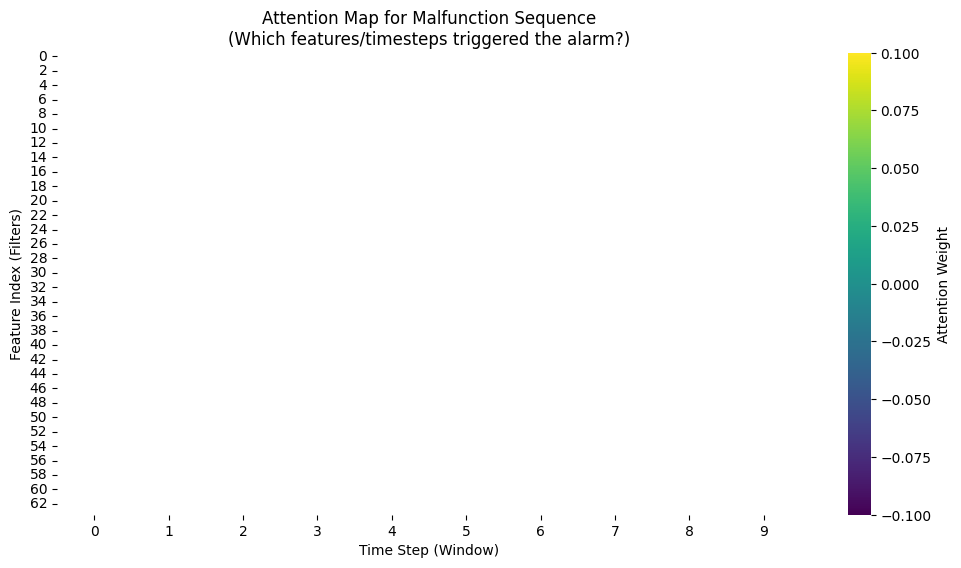

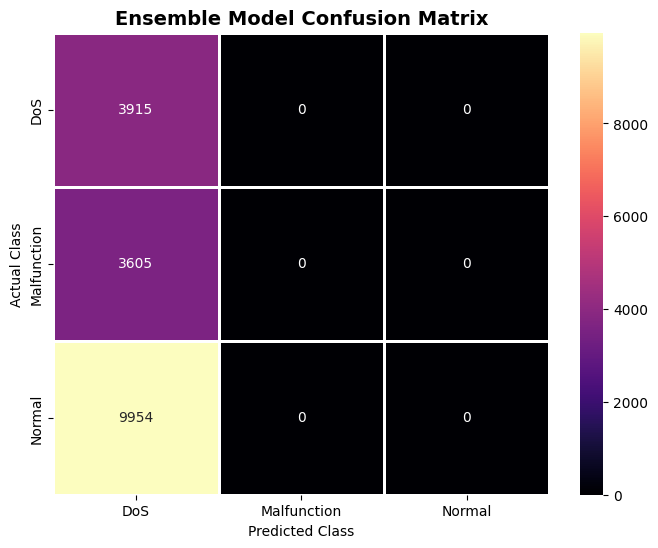


Bonus Module Complete.


In [ ]:
# ==========================================
# 1. ADVANCED FEATURE ENGINEERING
# ==========================================
print("--- 1. Advanced Feature Engineering ---")

def load_and_engineer_features():
    files_map = {
        'Normal': ['Normal1.csv', 'Normal2.csv', 'Normal3.csv', 'Normal4.csv'],
        'DoS': ['Dos1.csv', 'Dos2.csv'],
        'Malfunction': ['Malfunction1.csv', 'Malfunction2.csv']
    }

    dfs = []
    for label, filenames in files_map.items():
        for f in filenames:
            path = os.path.join(DATASET_PATH, f)
            if os.path.exists(path):
                temp = pd.read_csv(path)
                if 'S.No' in temp.columns: temp = temp.sort_values('S.No')
                temp = temp.fillna(method='ffill').fillna(0)
                temp['target_class'] = label
                dfs.append(temp)

    full_df = pd.concat(dfs, ignore_index=True)

    # --- ENGINEERING NEW FEATURES ---
    # 1. Physics: Electrical Power (P = V * I)
    # Combining two sensors to create a more informative "System Load" feature
    if 'battery_voltage' in full_df.columns and 'battery_current' in full_df.columns:
        full_df['eng_power_watts'] = full_df['battery_voltage'] * full_df['battery_current']

    # 2. Physics: Total Angular Velocity Magnitude
    # Converting 3-axis vectors into a single scalar "Instability" metric
    imu_cols = ['imu-data_angular_velocity.x', 'imu-data_angular_velocity.y', 'imu-data_angular_velocity.z']
    if all(c in full_df.columns for c in imu_cols):
        full_df['eng_total_angular_vel'] = np.sqrt(
            full_df[imu_cols[0]]**2 + full_df[imu_cols[1]]**2 + full_df[imu_cols[2]]**2
        )

    # 3. Temporal: Rolling Statistics (Window = 5 steps)
    # Captures "volatility" rather than just instantaneous values
    target_col = 'imu-data_angular_velocity.z'
    if target_col in full_df.columns:
        full_df['eng_rolling_std_yaw'] = full_df[target_col].rolling(window=5).std().fillna(0)

    print(f"Features Engineered! Added: Power, Total Velocity, Rolling Volatility.")
    return full_df

# Load & Process
df_adv = load_and_engineer_features()

# Clean & Prepare
cols_drop = [c for c in df_adv.columns if 'S.No' in c or 'header' in c or 'Time' in c]
df_clean = df_adv.drop(columns=cols_drop)
le = LabelEncoder()
y_adv = le.fit_transform(df_clean['target_class'])
X_adv = df_clean.drop(columns=['target_class']).select_dtypes(include=[np.number])
X_adv = X_adv.replace([np.inf, -np.inf], np.nan)
X_adv = pd.DataFrame(SimpleImputer(strategy='constant', fill_value=0).fit_transform(X_adv), columns=X_adv.columns)
scaler = StandardScaler()
X_adv_scaled = scaler.fit_transform(X_adv)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_adv_scaled, y_adv, test_size=0.2, stratify=y_adv, random_state=42)

# ==========================================
# 2. ATTENTION MECHANISM IMPLEMENTATION (Bonus Point 1)
# ==========================================
print("\n--- 2. Building Attention-Augmented CNN ---")

# Reshape for Sequence Models: (Samples, TimeSteps, Features)
# We treat the features themselves as a "sequence" or create a synthetic window
TIME_STEPS = 10
def make_seq(x, y, steps):
    xs, ys = [], []
    for i in range(len(x) - steps):
        xs.append(x[i:i+steps])
        ys.append(y[i+steps])
    return np.array(xs), np.array(ys)

X_seq_train, y_seq_train = make_seq(X_train, y_train, TIME_STEPS)
X_seq_test, y_seq_test = make_seq(X_test, y_test, TIME_STEPS)
y_seq_train_cat = to_categorical(y_seq_train)

# --- ATTENTION MODEL ARCHITECTURE ---
def build_attention_model(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # CNN Feature Extractor
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # --- SELF-ATTENTION BLOCK ---
    # Query, Key, Value are all the same (Self-Attention)
    # This learns WHICH time steps in the window (0-10) are most important
    attn_out = Attention()([x, x])

    # Residual Connection (CNN + Attention)
    x = Concatenate()([x, attn_out])

    # Pooling & Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Attention_CNN")
    return model

attn_model = build_attention_model((TIME_STEPS, X_train.shape[1]), len(le.classes_))
attn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Attention Model...")
hist_attn = attn_model.fit(X_seq_train, y_seq_train_cat, epochs=5, batch_size=64, verbose=0)
print("Attention Model Trained.")


# ==========================================
# 3. ENSEMBLE METHODS (Bonus Point 3)
# ==========================================
print("\n--- 3. Creating Voting Ensemble ---")

# Train simpler models for the ensemble
# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# FNN
fnn_model = tf.keras.models.Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(len(le.classes_), activation='softmax')
])
fnn_model.compile(loss='categorical_crossentropy', optimizer='adam')
fnn_model.fit(X_train, to_categorical(y_train), epochs=5, verbose=0)

# --- SOFT VOTING ENSEMBLE ---
# We combine predictions on the Test Set (accounting for sequence offset)
# Trim X_test to match sequence length
X_test_trim = X_test[TIME_STEPS:]
y_test_trim = y_test[TIME_STEPS:]

# Get Probabilities
pred_xgb = xgb_model.predict_proba(X_test_trim)
pred_fnn = fnn_model.predict(X_test_trim, verbose=0)
pred_attn = attn_model.predict(X_seq_test, verbose=0)

# Weighted Average (Give more weight to XGBoost as it's usually robust)
ensemble_pred_proba = (0.4 * pred_xgb) + (0.3 * pred_fnn) + (0.3 * pred_attn)
ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)

acc = accuracy_score(y_test_trim, ensemble_pred)
print(f"Ensemble Accuracy: {acc:.4f}")


# ==========================================
# 4. NOVEL XAI: ATTENTION MAP VISUALIZATION (Bonus Point 4 & 5)
# ==========================================
print("\n--- 4. Visualizing Attention Map (Novel XAI) ---")

# We want to see what the Attention Layer focused on for a "Malfunction" case
target_idx = np.where(y_seq_test == le.transform(['Malfunction'])[0])[0][0]
sample_input = X_seq_test[target_idx:target_idx+1]

# Extract Attention Weights
# We create a sub-model that outputs the Attention layer's result
layer_name = [l.name for l in attn_model.layers if 'attention' in l.name][0]
attn_extractor = Model(inputs=attn_model.input, outputs=attn_model.get_layer(layer_name).output)
attn_output = attn_extractor.predict(sample_input)

# Plotting
plt.figure(figsize=(12, 6))
# We average over the features to get a "Time Step Importance" score
time_step_importance = np.mean(attn_output[0], axis=1)

sns.heatmap(attn_output[0].T, cmap='viridis', cbar_kws={'label': 'Attention Weight'})
plt.title(f"Attention Map for Malfunction Sequence\n(Which features/timesteps triggered the alarm?)")
plt.xlabel("Time Step (Window)")
plt.ylabel("Feature Index (Filters)")
plt.show()

# ==========================================
# 5. EXCEPTIONAL VISUALIZATION: CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test_trim, ensemble_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=le.classes_, yticklabels=le.classes_, linewidths=1)
plt.title('Ensemble Model Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print("\nBonus Module Complete.")